In [12]:
import torch
import torch.nn as nn
import numpy as np

EPOCHS = 500
IN_SIZE = 5
NUM_SAMPLES = 5

def generate_data(rows, columns, samples):
	X = []
	y = []
	transformations = {
		'11': lambda x, y: x + y,
		'15': lambda x, y: x - y,
		'10': lambda x, y: x * y,
		'30': lambda x, y: x / y,
		'2': lambda x, y: x + y,
		}
	for j in range(samples):
		data_set = []
		for i in range(columns):
			data = []
			for val, fn in transformations.items():
				data.append(int(fn(int(val), i+j+1)))
			data_set.append(data)
		X.append(data_set)
		y.append([j+1])
	return X, y




In [13]:
X, y = generate_data(IN_SIZE, 3, NUM_SAMPLES)
X = torch.FloatTensor(X)
y = torch.LongTensor(y)


In [14]:
X.shape

torch.Size([5, 3, 5])

In [17]:
class RNN(nn.Module):
	def __init__(self):
		super(RNN, self).__init__()

self.rnn = nn.LSTM(
input_size=5,
hidden_size=NUM_SAMPLES+1,
num_layers=2,
batch_first=True,
    )

    def forward(self, x):
        out, (h_n, h_c) = self.rnn(x, None)
        return out[:, -1, :]	# Return output at last time-step

In [18]:



X, y = generate_data(IN_SIZE, 2, NUM_SAMPLES)
X = torch.FloatTensor(X)
y = torch.LongTensor(y)

rnn = RNN()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()     


for j in range(EPOCHS):
	for i, item in enumerate(X):
		item = item.unsqueeze(0)
		output = rnn(item)
		loss = loss_func(output, y[i])
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

	if j % 5 == 0:
		print('Loss: ', np.average(loss.detach()))

print('Testing:\n========')
for i, item in enumerate(X):
	print(y[i])
	outp = rnn(item.unsqueeze(0))
	print(np.argmax(outp.detach()))

Loss:  1.7038245
Loss:  1.6977987
Loss:  1.6912194
Loss:  1.6852239
Loss:  1.6797185
Loss:  1.6746771
Loss:  1.670292
Loss:  1.6661247
Loss:  1.661568
Loss:  1.6578254
Loss:  1.6551144
Loss:  1.6526159
Loss:  1.6503209
Loss:  1.6504378
Loss:  1.6531541
Loss:  1.6509528
Loss:  1.6471616
Loss:  1.6417133
Loss:  1.6332117
Loss:  1.6224278
Loss:  1.6100878
Loss:  1.5963761
Loss:  1.5813938
Loss:  1.5652723
Loss:  1.5481452
Loss:  1.53014
Loss:  1.5113792
Loss:  1.4919777
Loss:  1.4720434
Loss:  1.4516757
Loss:  1.4309648
Loss:  1.409991
Loss:  1.3888255
Loss:  1.3675321
Loss:  1.3461736
Loss:  1.3248203
Loss:  1.3035632
Loss:  1.2825264
Loss:  1.2618731
Loss:  1.2418096
Loss:  1.2225635
Loss:  1.204271
Loss:  1.1870277
Loss:  1.1709806
Loss:  1.1562387
Loss:  1.1428763
Loss:  1.1309279
Loss:  1.1204059
Loss:  1.1113287
Loss:  1.1037747
Loss:  1.0979922
Loss:  1.094652
Loss:  1.0953122
Loss:  1.1017231
Loss:  1.1087108
Loss:  1.1078317
Loss:  1.1036261
Loss:  1.099359
Loss:  1.0949875
Loss:

In [24]:
print(item.shape)
print(item.unsqueeze(0).shape)


torch.Size([2, 5])
torch.Size([1, 2, 5])


# Multivariate many to many



4
I would like to implement LSTM for multivariate input in Pytorch.

Following this article https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ which uses keras, the input data are in shape of (number of samples, number of timesteps, number of parallel features)

in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
. . . 
Input     Output
[[10 15]
 [20 25]
 [30 35]] 65
[[20 25]
 [30 35]
 [40 45]] 85
[[30 35]
 [40 45]
 [50 55]] 105
[[40 45]
 [50 55]
 [60 65]] 125
[[50 55]
 [60 65]
 [70 75]] 145
[[60 65]
 [70 75]
 [80 85]] 165
[[70 75]
 [80 85]
 [90 95]] 185

n_timesteps = 3
n_features = 2
In keras it seems to be easy:

model.add(LSTM(50, activation='relu', input_shape=(n_timesteps, n_features)))

Can it be done in other way, than creating n_features of LSTMs as first layer and feed each separately (imagine as multiple streams of sequences) and then flatten their output to linear layer?

I'm not 100% sure but by nature of LSTM the input cannot be flattened and passed as 1D array, because each sequence "plays by different rules" which the LSTM is supposed to learn.

So how does such implementation with keras equal to PyTorch input of shape (seq_len, batch, input_size)(source https://pytorch.org/docs/stable/nn.html#lstm)

In [212]:
import random
import numpy as np
import torch

# multivariate data preparation
from numpy import array
from numpy import hstack
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
# define input sequence
in_seq1 = array([x for x in range(0,100,10)])
in_seq2 = array([x for x in range(5,105,10)])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))

In [213]:
print(in_seq1.shape)
print(in_seq2.shape)
print(out_seq.shape)


(10, 1)
(10, 1)
(10, 1)


In [237]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length,output_values=1):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)
        self.output_values=output_values
    
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, output_values)
        
    
    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)
    
    
    def forward(self, x):        
        batch_size, seq_len, _ = x.size()
        
        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        print(x.shape)
        out=self.l_linear(x)
        #return self.l_linear(x)
        return x,out

In [216]:
n_features = 2 # this is number of parallel inputs
n_timesteps = 4 # this is number of timesteps

# convert dataset into input/output
X, y = split_sequences(dataset, n_timesteps)
print(X.shape, y.shape)

# create NN
mv_net = MV_LSTM(n_features,n_timesteps)
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-1)

train_episodes = 500
batch_size = 16

(7, 4, 2) (7,)


In [463]:
y

array([ 45,  65,  85, 105, 125, 145, 165, 185])

In [295]:
output_model.view(-1)

tensor([-0.1889, -0.2185,  0.0583, -0.1242,  0.0382, -0.4744, -0.2287,  0.1097,
        -0.0973,  0.0178, -0.0937, -0.0162, -0.1122, -0.0310, -0.1566, -0.1122,
        -0.0310, -0.1566, -0.1122, -0.0310, -0.1566, -0.1122, -0.0310, -0.1566],
       grad_fn=<ViewBackward>)

In [56]:
mv_net.train()
for t in range(train_episodes):
    for b in range(0,len(X),batch_size):
        optimizer.zero_grad()
        inpt = X[b:b+batch_size,:,:]
        target = y[b:b+batch_size]    
        
        x_batch = torch.tensor(inpt,dtype=torch.float32)    
        y_batch = torch.tensor(target,dtype=torch.float32)
    
        mv_net.init_hidden(x_batch.size(0))
    #    lstm_out, _ = mv_net.l_lstm(x_batch,nnet.hidden)    
    #    lstm_out.contiguous().view(x_batch.size(0),-1)
        output = mv_net(x_batch) 
        loss = criterion(output.view(-1), y_batch)  
        
        loss.backward()
        optimizer.step()        
        optimizer.zero_grad()
    if t%50==0:
        print('step : ' , t , 'loss : ' , loss.item())

step :  0 loss :  0.005418463610112667
step :  50 loss :  0.0038068764843046665
step :  100 loss :  0.0026473659090697765
step :  150 loss :  0.001821596291847527
step :  200 loss :  0.0012401746353134513
step :  250 loss :  0.0008350973948836327
step :  300 loss :  0.0005560870631597936
step :  350 loss :  0.00036595095298253
step :  400 loss :  0.00023786402016412467
step :  450 loss :  0.0001529715082142502


# Example 3

In [615]:
X_train = []
y_train = []
# Creating a data structure with n timesteps which is 10 in our example
print(train_size + timesteps)
for i in range(timesteps, train_size + timesteps): 
    X_train.append(X_train_set[i-timesteps:i,:])
    y_train.append(y_train_set[i:i+timesteps])
print('len(X_train)',len(X_train))
print('len(y_train)',len(y_train))
#create X_train matrix
#10 items per array (timestep) 
print('np.array(X_train).shape',np.array(X_train).shape)
print('X_train[1].shap',X_train[1].shape)
#create Y_train matrix
#10 items per array (as much as timestep) 
print('y_train[0:2]',y_train[0:2])
print('np.array(y_train).shape',np.array(y_train).shape)
print('############################')
print('############################')
print('############################')
# Do the same for your test data
X_test = []
y_test = []
# Creating a data structure with n timesteps
print(test_size + timesteps)
for i in range(timesteps, test_size + timesteps): 
    X_test.append(X_test_set[i-timesteps:i,:])
    y_test.append(y_test_set[i:i+timesteps])
print('len(X_test)',len(X_test))
print('len(y_test)',len(y_test))
#create X_test matrix
#10 items per array (timestep) 
print('np.array(X_test).shape',np.array(X_test).shape)
print('X_test[1].shape',X_test[1].shape)
#10 items per array (timestep) 
print('y_test[0:2]',y_test[0:2])
print('np.array(y_test).shape',np.array(y_test).shape)

NameError: name 'train_size' is not defined

# trying it in the GL example


In [13]:
import numpy as np
import pandas as pd

In [3]:

df_halo=pd.read_csv('halo_vs_non_halo_ops_ccp.csv')


In [4]:
df_halo.sample(2)

,store_id,first_date,gl,Direct_OPS,Halo_OPS,total_ops,ops,net_ccp,gross_cplf
7153661,yearmirr07206-20,2019-11-01,641.0,0.00,26.50,26.50,26.50,6.183704,13.08
3998051,alomil0f-20,2020-02-01,23.0,31.26,77.77,109.03,113.22,30.696362,11.27


In [ ]:
df_halo=pd.read_csv('halo_vs_non_halo_ops_ccp.csv')
df_sample=df_halo.merge(df_halo[['store_id']].drop_duplicates().sample(5000),
                       on='store_id',
                       how='inner')
del df_halo
gl_top_30=[147,201,121,200,79,21,193,194,60,14,107,23,421,263,86,468,469,199,309,229,196,325,328,267,75,63,351,504,198,228]
df_sample['gl_top_30']=np.where(df_sample['gl'].isin(gl_top_30[:4]),
                                df_sample['gl'],
                                '-999'
                               )
columns=list(set(df_sample['gl_top_30'].values))

df_sample[['Direct_OPS','Halo_OPS','total_ops','ops','net_ccp','gross_cplf']]=df_sample[['Direct_OPS','Halo_OPS','total_ops','ops','net_ccp','gross_cplf']].fillna(0)
df_sample['first_date']=pd.to_datetime(df_sample['first_date'])
df_sample_1=df_sample.groupby(['store_id','first_date','gl_top_30']).agg({'Direct_OPS':sum,
                                                             'Halo_OPS':sum,
                                                             'total_ops':sum,
                                                             'net_ccp':sum}).reset_index()
df_sample_1=df_sample_1.set_index(['store_id','first_date','gl_top_30']).unstack(level=[2,1]).fillna(0)


In [5]:
df_sample=df_halo.merge(df_halo[['store_id']].drop_duplicates().sample(3000),
                       on='store_id',
                       how='inner')

In [6]:
print(df_sample.shape)
print(df_sample.store_id.nunique())

(59182, 9)
3000


In [7]:
del df_halo

In [8]:
gl_top_30=[147,201,121,200,79,21,193,194,60,14,107,23,421,263,86,468,469,199,309,229,196,325,328,267,75,63,351,504,198,228]

In [14]:
df_sample['gl_top_30']=np.where(df_sample['gl'].isin(gl_top_30[:2]),
                                df_sample['gl'],
                                '-999'
                               )
columns=list(set(df_sample['gl_top_30'].values))

In [15]:
df_sample[['Direct_OPS','Halo_OPS','total_ops','ops','net_ccp','gross_cplf']]=df_sample[['Direct_OPS','Halo_OPS','total_ops','ops','net_ccp','gross_cplf']].fillna(0)



In [16]:
df_sample['first_date']=pd.to_datetime(df_sample['first_date'])
df_sample_1=df_sample.groupby(['store_id','first_date','gl_top_30']).agg({'Direct_OPS':sum,
                                                             'Halo_OPS':sum,
                                                             'total_ops':sum,
                                                             'net_ccp':sum}).reset_index()
df_sample_1=df_sample_1.set_index(['store_id','first_date','gl_top_30']).unstack(level=[2,1]).fillna(0)

In [ ]:
seq_frame=2
start_frame=1
total_time_stamps=df_sample_1['total_ops'].shape[1]
target_stamp_start=start_frame+seq_frame
time_steps=np.arange(target_stamp_start,total_time_stamps,1)
features=

In [137]:
X=[]
y=[]
for i in time_steps:
    feature_end=i-1
    feature_start=feature_end-seq_frame
    features=df_sample_1['total_ops'].iloc[:,feature_start:feature_end].values
    target=df_sample_1['total_ops'].iloc[:,i].values
    X.append(features)
    y.append(target)

In [552]:
feature_array_1=[]
target_array_1=[]

seq_frame=3
start_frame=1
#total_time_stamps=df_sample_1['total_ops'].shape[1]
#target_stamp_start=start_frame+seq_frame
#time_steps=np.arange(target_stamp_start,total_time_stamps,1)
feature='Direct_OPS'
feature_1='Direct_OPS'
month_values=pd.Series(sorted(set(df_sample_1.columns.get_level_values(2))))
#gls=pd.Series(sorted(set(df_sample_1.columns.get_level_values(1))))

total_time_stamps=len(month_values)
time_steps=np.arange(total_time_stamps)
target_stamp_start=seq_frame+1
target_time_steps=np.arange(target_stamp_start,total_time_stamps)
i=0
target_month=month_values[target_time_steps[i]]
feature_months=month_values[target_time_steps[i]-2:target_time_steps[i]]
target=df_sample_1.loc[ :,(feature,slice(None),target_month)]
features=df_sample_1.loc[ :,(feature_1,slice(None),feature_months)][feature_1]
gls=list(set(features.columns.get_level_values(0)))
target_values=target.values
#feature_list_1=features[gls[0]].values
#feature_list_2=features[gls[1]].values
feature_list=[]
for gl in gls:
    feature_list.append(features[gl].values)
feature_array=array(feature_list)
feature_array=np.transpose(feature_array,(1,0,2))

feature_array_1.append(feature_array)
target_array_1.append(target_values)

In [138]:
df_sample_2=df_sample_1.swaplevel(0,2,axis=1).swaplevel(1,2,axis=1).stack(0)
feature=df_sample_2.swaplevel(1,0,axis=0)[['Direct_OPS','Halo_OPS']]
feature.columns=feature.columns.map('_'.join).str.strip('|')
feature_names=feature.columns
target_names=df_sample_2.swaplevel(1,0,axis=0)[['Direct_OPS']].columns.map('_'.join).str.strip('|')
feature_df=feature.reset_index()

In [186]:
#store_feature=feature_df.query('store_id=="techupdate09-20"')
store_feature=feature_df.query('store_id=="techupdate09-20"|store_id=="thestegui09-20"')


In [189]:
store_feature

,first_date,store_id,Direct_OPS_-999,Direct_OPS_147.0,Direct_OPS_201.0,Halo_OPS_-999,Halo_OPS_147.0,Halo_OPS_201.0
15216,2019-10-01,techupdate09-20,13736.42,83.68,59.00,15153.24,1586.49,536.85
15217,2019-11-01,techupdate09-20,14065.72,78.35,125.92,16293.61,969.70,909.51
15218,2019-12-01,techupdate09-20,21281.44,103.64,945.89,21856.48,1334.33,1703.18
15219,2020-01-01,techupdate09-20,13490.32,64.60,380.72,14350.87,1044.80,836.72
15220,2020-02-01,techupdate09-20,10989.36,38.85,224.93,13237.01,678.85,394.82
15221,2020-03-01,techupdate09-20,8791.04,0.00,469.74,9618.83,1205.35,548.53
15954,2019-10-01,thestegui09-20,64.81,0.00,0.00,101.94,0.00,44.99
15955,2019-11-01,thestegui09-20,49.41,0.00,0.00,52.22,0.00,0.00
15956,2019-12-01,thestegui09-20,77.02,0.00,0.00,0.00,0.00,33.03
15957,2020-01-01,thestegui09-20,136.56,0.00,0.00,186.43,0.00,9.99


In [646]:
start_index

Timestamp('2019-10-01 00:00:00')

In [21]:
feature_df=feature.reset_index()

In [36]:

start_index=month_seris[starting_numeric_index]

#step_length=(start_index-end_index)/(len(month_seris)-len_time_steps)
#for i in np.arange(start_index,end_index,):
    #indices=np.arange(start_index)
    #print(i)
    #print(store_feature[store_feature[column_to_index]==i])



In [137]:
i+len_time_steps

5

In [144]:
month_seris[i+len_time_steps+1]

Timestamp('2020-01-01 00:00:00')

In [149]:
month_seris[i+len_time_steps+1]

Timestamp('2020-01-01 00:00:00')

In [150]:
store_feature[store_feature[column_to_index]==month_seris[i+len_time_steps+1]]

,first_date,store_id,Direct_OPS_-999,Direct_OPS_147.0,Direct_OPS_201.0,Halo_OPS_-999,Halo_OPS_147.0,Halo_OPS_201.0
15219,2020-01-01,techupdate09-20,13490.32,64.6,380.72,14350.87,1044.8,836.72


In [304]:
#store_feature_1=feature_df.query('store_id=="techupdate09-20"|store_id=="thestegui09-20"')
store_feature_1=feature_df#.query('store_id=="techupdate09-20"|store_id=="thestegui09-20"')


In [190]:
for store in set(store_feature.store_id):
    print(store)

thestegui09-20
techupdate09-20


In [305]:
column_to_index='first_date'
month_seris=pd.Series(sorted(set(feature_df[column_to_index])))
len_time_steps=2
starting_numeric_index=0
ending_numeric_index=len(month_seris)-len_time_steps
non_features=[i for i in feature_df.columns if i not in feature_names]
non_features_for_modelling=[]
features_for_modelling=[]
target_for_modelling=[]
for store in set(store_feature_1.store_id):
    store_feature=store_feature_1[store_feature_1['store_id']==store]
    for i in np.arange(starting_numeric_index,ending_numeric_index):
        #print(i)
        #print(month_seris[i:i+len_time_steps])
        store_feature_for_the_iteration=store_feature[store_feature[column_to_index].isin(month_seris[i:i+len_time_steps])][feature_names]
        non_store_feature_for_the_iteration=store_feature[store_feature[column_to_index].isin(month_seris[i:i+len_time_steps])][non_features]
        target_feature_for_the_iteration=store_feature[store_feature[column_to_index]==month_seris[i+len_time_steps]][target_names]
        features_for_modelling.append(store_feature_for_the_iteration.values)
        non_features_for_modelling.append(non_store_feature_for_the_iteration.values)
        target_for_modelling.append(target_feature_for_the_iteration.values)

model_X=np.array(features_for_modelling)
target_Y=np.array(target_for_modelling)

In [306]:
print(model_X.shape)
print(target_Y.shape)

(12000, 2, 6)
(12000, 1, 3)


In [524]:
import torch.nn.functional as F

In [528]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length,output_values=1):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)
        self.output_values=output_values
    
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        #print(self.n_hidden)
        #print(self.seq_len)
        #print(seq_length)
        #print(self.n_hidden*self.seq_len)
        
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, output_values)
        
    
    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)
    
    
    def forward(self, x):        
        batch_size, seq_len, _ = x.size()
        
        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        #print(x.shape)
        #out=self.l_linear(x)
        x=F.relu(x)
        return self.l_linear(x)
        #return x,out
    
    
n_features=model_X.shape[2]
n_timestep=model_X.shape[1]
output_values=target_Y.shape[2]
mv_net = MV_LSTM(n_features,n_timestep,output_values)

#x_batch = torch.tensor(model_X,dtype=torch.float32)    
#y_batch = torch.tensor(target_Y,dtype=torch.float32)

#mv_net.init_hidden(x_batch.size(0))

In [529]:

# output_model=mv_net(x_batch)
# output_model=output_model.unsqueeze(1)
# output_model.view(-1).shape
# y_batch.shape
# #.shape

In [530]:
mv_net.train()
for t in range(train_episodes):
    for b in range(0,len(X),batch_size):
        optimizer.zero_grad()
        inpt = X[b:b+batch_size,:,:]
        target = y[b:b+batch_size]    
        
        x_batch = torch.tensor(inpt,dtype=torch.float32)    
        y_batch = torch.tensor(target,dtype=torch.float32)
    
        mv_net.init_hidden(x_batch.size(0))
    #    lstm_out, _ = mv_net.l_lstm(x_batch,nnet.hidden)    
    #    lstm_out.contiguous().view(x_batch.size(0),-1)
        output = mv_net(x_batch) 
        loss = criterion(output.view(-1), y_batch)  
        
        loss.backward()
        optimizer.step()        
        optimizer.zero_grad()
    if t%50==0:
        print('step : ' , t , 'loss : ' , loss.item())

RuntimeError: input.size(-1) must be equal to input_size. Expected 21, got 2

In [285]:
target_Y.shape

(8, 1, 3)

In [290]:
output_model.unsqueeze(1).shape

torch.Size([8, 1, 3])

In [263]:
n_features

2

In [258]:
X.shape

(7, 4, 2)

In [249]:
n_timesteps

4

In [243]:
mv_net

MV_LSTM(
  (l_lstm): LSTM(6, 20, batch_first=True)
  (l_linear): Linear(in_features=80, out_features=1, bias=True)
)

In [244]:
n_timestep

2

In [240]:
x_batch.shape

torch.Size([8, 2, 6])

torch.Size([8, 40])


(tensor([[-1.4605e-10,  3.6516e-15, -3.9177e-08, -1.2141e-03,  1.9423e-13,
          -1.8112e-03,  4.5679e-13, -2.5195e-07,  4.3536e-01,  7.6159e-01,
           1.0594e-05, -7.1467e-05, -8.0673e-11,  2.0541e-07,  1.4053e-05,
          -2.2703e-05, -1.6628e-02, -7.6018e-01,  6.2527e-15, -5.1137e-22,
          -2.9734e-06,  2.2910e-08, -4.6745e-07, -1.9301e-01,  9.7930e-04,
          -7.4684e-03,  7.6220e-03, -8.8545e-05,  6.2699e-04,  8.4632e-01,
           2.9151e-04, -2.8093e-02,  2.5670e-10,  1.0551e-03,  1.9921e-04,
          -6.8159e-01, -3.0499e-03, -5.2496e-01,  5.9434e-06, -9.6904e-11],
         [-4.0565e-06,  2.6649e-08, -3.2313e-07, -1.7887e-01,  1.0403e-03,
          -5.3878e-03,  8.2386e-03, -1.2562e-04,  3.9073e-04,  7.5997e-01,
           2.0435e-04, -3.4006e-02,  3.8039e-10,  8.3854e-04,  2.1725e-04,
          -6.8613e-01,  3.4383e-03, -4.2503e-01,  6.8033e-06, -1.1435e-10,
           6.5860e-01,  2.5244e-08, -8.4974e-13, -8.6308e-01,  9.5599e-03,
           4.3556e-01,  

In [225]:
model_X

array([[[6.481000e+01, 0.000000e+00, 0.000000e+00, 1.019400e+02,
         0.000000e+00, 4.499000e+01],
        [4.941000e+01, 0.000000e+00, 0.000000e+00, 5.222000e+01,
         0.000000e+00, 0.000000e+00]],

       [[4.941000e+01, 0.000000e+00, 0.000000e+00, 5.222000e+01,
         0.000000e+00, 0.000000e+00],
        [7.702000e+01, 0.000000e+00, 0.000000e+00, 0.000000e+00,
         0.000000e+00, 3.303000e+01]],

       [[7.702000e+01, 0.000000e+00, 0.000000e+00, 0.000000e+00,
         0.000000e+00, 3.303000e+01],
        [1.365600e+02, 0.000000e+00, 0.000000e+00, 1.864300e+02,
         0.000000e+00, 9.990000e+00]],

       [[1.365600e+02, 0.000000e+00, 0.000000e+00, 1.864300e+02,
         0.000000e+00, 9.990000e+00],
        [8.380000e+00, 0.000000e+00, 0.000000e+00, 2.086700e+02,
         0.000000e+00, 0.000000e+00]],

       [[1.373642e+04, 8.368000e+01, 5.900000e+01, 1.515324e+04,
         1.586490e+03, 5.368500e+02],
        [1.406572e+04, 7.835000e+01, 1.259200e+02, 1.629361e+04,


TypeError: 'int' object is not callable

In [554]:
feature_array.shape

(3000, 3, 2)

In [ ]:
feature='Direct_OPS'

i=time_steps[0]  #target i 
feature_end=i-1
feature_start=feature_end-seq_frame
feature_window=list(np.arange(feature_start,feature_end))
 
y=df_sample_1.loc[ :,(feature,slice(None),month_values[i])]
#X=df_sample_1.loc[ :,(feature,slice(None),[array(month_values)[[1,2]]])]


In [316]:
df_sample_1.loc[ :,('Direct_OPS',slice(None),['2019-11-01'])]
#df_sample_1.xs()

Direct_OPS                      
gl_top_30             147.0       -999      201.0
first_date       2019-11-01 2019-11-01 2019-11-01
store_id                                         
072304-20              0.00       0.00       0.00
07301994-20            0.00       0.00       0.00
090288020101-20        0.00       0.00       0.00
10150309-20            0.00    1580.34      81.80
101mediagroup-20       0.00       0.00       0.00
...                     ...        ...        ...
zikuzgun08-20          0.00       0.00       0.00
zionlion02-20          0.00       0.00       0.00
zionpillars-20         0.00       0.00       0.00
zlifehealth00-20       0.00       0.00       0.00
zlinefitness-20       17.01     375.00      78.98

[3000 rows x 3 columns]

# Clean Code


## reading in the dataset

In [344]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader ,TensorDataset

In [515]:
df_halo=pd.read_csv('halo_vs_non_halo_ops_ccp.csv')

df_sample=df_halo.merge(df_halo[['store_id']].drop_duplicates().sample(30000),
                       on='store_id',
                       how='inner')
del df_halo
gl_top_30=[147,201,121,200,79,21,193,194,60,14,107,23,421,263,86,468,469,199,309,229,196,325,328,267,75,63,351,504,198,228]
df_sample['gl_top_30']=np.where(df_sample['gl'].isin(gl_top_30[:6]),
                                df_sample['gl'],
                                '-999'
                               )
columns=list(set(df_sample['gl_top_30'].values))

df_sample[['Direct_OPS','Halo_OPS','total_ops','ops','net_ccp','gross_cplf']]=df_sample[['Direct_OPS','Halo_OPS','total_ops','ops','net_ccp','gross_cplf']].fillna(0)
df_sample['first_date']=pd.to_datetime(df_sample['first_date'])
df_sample_1=df_sample.groupby(['store_id','first_date','gl_top_30']).agg({'Direct_OPS':sum,
                                                             'Halo_OPS':sum,
                                                             'total_ops':sum,
                                                             'net_ccp':sum}).reset_index()
df_sample_1=df_sample_1.set_index(['store_id','first_date','gl_top_30']).unstack(level=[2,1]).fillna(0)


In [516]:
feature_names=['Direct_OPS','Halo_OPS','total_ops']
#target_feature=['Direct_OPS']
target_feature=['total_ops']
df_sample_2=df_sample_1.swaplevel(0,2,axis=1).swaplevel(1,2,axis=1).stack(0)
feature=df_sample_2.swaplevel(1,0,axis=0)[feature_names]
feature.columns=feature.columns.map('_'.join).str.strip('|')
feature_names=feature.columns
target_names=df_sample_2.swaplevel(1,0,axis=0)[target_feature].columns.map('_'.join).str.strip('|')
feature_df=feature.reset_index()
store_feature_1=feature_df

In [518]:
column_to_index='first_date'
month_seris=pd.Series(sorted(set(feature_df[column_to_index])))
len_time_steps=3
starting_numeric_index=0
ending_numeric_index=len(month_seris)-len_time_steps
non_features=[i for i in feature_df.columns if i not in feature_names]
non_features_for_modelling=[]
features_for_modelling=[]
target_for_modelling=[]
for store in set(store_feature_1.store_id):
    store_feature=store_feature_1[store_feature_1['store_id']==store]
    for i in np.arange(starting_numeric_index,ending_numeric_index):
        #print(i)
        #print(month_seris[i:i+len_time_steps])
        store_feature_for_the_iteration=store_feature[store_feature[column_to_index].isin(month_seris[i:i+len_time_steps])][feature_names]
        non_store_feature_for_the_iteration=store_feature[store_feature[column_to_index].isin(month_seris[i:i+len_time_steps])][non_features]
        target_feature_for_the_iteration=store_feature[store_feature[column_to_index]==month_seris[i+len_time_steps]][target_names]
        features_for_modelling.append(store_feature_for_the_iteration.values)
        non_features_for_modelling.append(non_store_feature_for_the_iteration.values)
        target_for_modelling.append(target_feature_for_the_iteration.values)

model_X=np.array(features_for_modelling)
target_Y=np.array(target_for_modelling)
non_feature_array=np.array(non_features_for_modelling)

In [531]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length,output_values=1):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)
        self.output_values=output_values
        
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        #print(self.n_hidden)
        #print(self.seq_len)
        #print(seq_length)
        #print(self.n_hidden*self.seq_len)
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, output_values)
        
    
    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)
    
    
    def forward(self, x):        
        batch_size, seq_len, _ = x.size()
        
        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        #print(x.shape)
        #out=self.l_linear(x)
        x=F.relu(x)
        return self.l_linear(x)
        #return x,out
    
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-1)
   
n_features=model_X.shape[2]
n_timestep=model_X.shape[1]
output_values=target_Y.shape[2]
mv_net = MV_LSTM(n_features,n_timestep,output_values)


model_X=torch.tensor(model_X,dtype=torch.float32)
target_Y=torch.tensor(target_Y,dtype=torch.float32)
index_tensor=torch.from_numpy(np.arange(model_X.shape[0]))
dataset = torch.utils.data.TensorDataset(model_X, target_Y,index_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

#non_feature_array=torch.tensor(non_feature_array)
#feat_list=[non_feature_array,model_X,target_Y]

/Users/jauharim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/jauharim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [488]:
# iterator=iter(dataloader)
# x_iter, y_iter,i_iter=iterator.next()

In [521]:

# mv_net.eval()
# mv_net.init_hidden(x_iter.size(0))
# output=mv_net(x_iter).unsqueeze(1)
# loss = criterion(output, y_iter)  

In [532]:
loss_list=[]
epochs=500
mv_net.train()
for e in range(epochs):
    batch_num=0
    for x_iter, y_iter,i_iter in dataloader:
        batch_num=batch_num+1
        
        optimizer.zero_grad()
        mv_net.init_hidden(x_iter.size(0))
        output=mv_net(x_iter).unsqueeze(1)
        loss = criterion(output, y_iter)
        
        loss.backward()
        optimizer.step() 
        if batch_num%50==0:
            loss_list.append(round(loss.item()/len(i_iter),2))
        if e%20==0 and batch_num%50==0:
            print('epoch : ',e, 'batch_num : ' , batch_num , 'loss : ' , round(loss.item()/len(i_iter),2))

epoch :  0 batch_num :  50 loss :  8036.84
epoch :  0 batch_num :  100 loss :  158354.12
epoch :  0 batch_num :  150 loss :  6999.55
epoch :  0 batch_num :  200 loss :  64271.29
epoch :  0 batch_num :  250 loss :  20776.21
epoch :  0 batch_num :  300 loss :  2984.34
epoch :  0 batch_num :  350 loss :  21304.76
epoch :  0 batch_num :  400 loss :  2806.18
epoch :  0 batch_num :  450 loss :  13500.81
epoch :  0 batch_num :  500 loss :  4298.8
epoch :  0 batch_num :  550 loss :  187572.11
epoch :  0 batch_num :  600 loss :  23665.32
epoch :  0 batch_num :  650 loss :  5285.75
epoch :  0 batch_num :  700 loss :  2302.96
epoch :  20 batch_num :  50 loss :  33552.47
epoch :  20 batch_num :  100 loss :  5289.3
epoch :  20 batch_num :  150 loss :  155073.97
epoch :  20 batch_num :  200 loss :  11525.14
epoch :  20 batch_num :  250 loss :  1984.87
epoch :  20 batch_num :  300 loss :  7138.45
epoch :  20 batch_num :  350 loss :  19598.7
epoch :  20 batch_num :  400 loss :  49992.24
epoch :  20 ba

epoch :  240 batch_num :  600 loss :  982.7
epoch :  240 batch_num :  650 loss :  8548.77
epoch :  240 batch_num :  700 loss :  38918.98
epoch :  260 batch_num :  50 loss :  32774.84
epoch :  260 batch_num :  100 loss :  92353.17
epoch :  260 batch_num :  150 loss :  6733.41
epoch :  260 batch_num :  200 loss :  51968.75
epoch :  260 batch_num :  250 loss :  48152.19
epoch :  260 batch_num :  300 loss :  129620.5
epoch :  260 batch_num :  350 loss :  12698.43
epoch :  260 batch_num :  400 loss :  2833.74
epoch :  260 batch_num :  450 loss :  92978.75
epoch :  260 batch_num :  500 loss :  2202.34
epoch :  260 batch_num :  550 loss :  110.93
epoch :  260 batch_num :  600 loss :  3931.75
epoch :  260 batch_num :  650 loss :  6969.25
epoch :  260 batch_num :  700 loss :  2027.11
epoch :  280 batch_num :  50 loss :  2643.87
epoch :  280 batch_num :  100 loss :  53911.79
epoch :  280 batch_num :  150 loss :  14320.77
epoch :  280 batch_num :  200 loss :  491715.5
epoch :  280 batch_num :  25

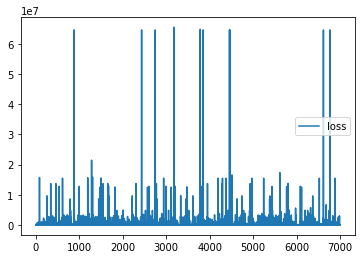

In [533]:
pd.DataFrame({'loss':loss_list},index=np.arange(len(loss_list))).plot()

# with mean absolute error and clipping gradient

In [535]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length,output_values=1):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)
        self.output_values=output_values
    
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        #print(self.n_hidden)
        #print(self.seq_len)
        #print(seq_length)
        #print(self.n_hidden*self.seq_len)
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, output_values)
        
    
    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)
    
    
    def forward(self, x):        
        batch_size, seq_len, _ = x.size()
        
        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        #print(x.shape)
        #out=self.l_linear(x)
        x=F.relu(x)
        return self.l_linear(x)
        #return x,out
    
criterion = torch.nn.L1Loss() # 
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-1)
   
n_features=model_X.shape[2]
n_timestep=model_X.shape[1]
output_values=target_Y.shape[2]
mv_net = MV_LSTM(n_features,n_timestep,output_values)


model_X=torch.tensor(model_X,dtype=torch.float32)
target_Y=torch.tensor(target_Y,dtype=torch.float32)
index_tensor=torch.from_numpy(np.arange(model_X.shape[0]))
dataset = torch.utils.data.TensorDataset(model_X, target_Y,index_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

#non_feature_array=torch.tensor(non_feature_array)
#feat_list=[non_feature_array,model_X,target_Y]

/Users/jauharim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/jauharim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [536]:
clip_value=25
loss_list=[]
epochs=500
mv_net.train()
for e in range(epochs):
    batch_num=0
    for x_iter, y_iter,i_iter in dataloader:
        batch_num=batch_num+1
        
        optimizer.zero_grad()
        mv_net.init_hidden(x_iter.size(0))
        output=mv_net(x_iter).unsqueeze(1)
        loss = criterion(output, y_iter)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm(mv_net.parameters(), clip_value)

        optimizer.step() 
        if batch_num%50==0:
            loss_list.append(round(loss.item()/len(i_iter),2))
        if e%20==0 and batch_num%50==0:
            print('epoch : ',e, 'batch_num : ' , batch_num , 'loss : ' , round(loss.item()/len(i_iter),2))

/Users/jauharim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  app.launch_new_instance()


epoch :  0 batch_num :  50 loss :  0.66
epoch :  0 batch_num :  100 loss :  2.0
epoch :  0 batch_num :  150 loss :  0.5
epoch :  0 batch_num :  200 loss :  0.71
epoch :  0 batch_num :  250 loss :  0.59
epoch :  0 batch_num :  300 loss :  1.05
epoch :  0 batch_num :  350 loss :  1.79
epoch :  0 batch_num :  400 loss :  0.97
epoch :  0 batch_num :  450 loss :  1.2
epoch :  0 batch_num :  500 loss :  1.14
epoch :  0 batch_num :  550 loss :  0.7
epoch :  0 batch_num :  600 loss :  0.25
epoch :  0 batch_num :  650 loss :  1.47
epoch :  0 batch_num :  700 loss :  0.33
epoch :  20 batch_num :  50 loss :  1.54
epoch :  20 batch_num :  100 loss :  0.97
epoch :  20 batch_num :  150 loss :  0.73
epoch :  20 batch_num :  200 loss :  0.39
epoch :  20 batch_num :  250 loss :  1.49
epoch :  20 batch_num :  300 loss :  1.32
epoch :  20 batch_num :  350 loss :  1.67
epoch :  20 batch_num :  400 loss :  0.79
epoch :  20 batch_num :  450 loss :  0.81
epoch :  20 batch_num :  500 loss :  2.9
epoch :  20 b

epoch :  260 batch_num :  650 loss :  5.74
epoch :  260 batch_num :  700 loss :  1.54
epoch :  280 batch_num :  50 loss :  13.12
epoch :  280 batch_num :  100 loss :  2.5
epoch :  280 batch_num :  150 loss :  0.85
epoch :  280 batch_num :  200 loss :  2.74
epoch :  280 batch_num :  250 loss :  6.1
epoch :  280 batch_num :  300 loss :  0.81
epoch :  280 batch_num :  350 loss :  1.17
epoch :  280 batch_num :  400 loss :  0.63
epoch :  280 batch_num :  450 loss :  0.82
epoch :  280 batch_num :  500 loss :  0.83
epoch :  280 batch_num :  550 loss :  0.96
epoch :  280 batch_num :  600 loss :  5.05
epoch :  280 batch_num :  650 loss :  0.25
epoch :  280 batch_num :  700 loss :  2.59
epoch :  300 batch_num :  50 loss :  1.33
epoch :  300 batch_num :  100 loss :  1.2
epoch :  300 batch_num :  150 loss :  1.35
epoch :  300 batch_num :  200 loss :  0.74
epoch :  300 batch_num :  250 loss :  8.06
epoch :  300 batch_num :  300 loss :  0.5
epoch :  300 batch_num :  350 loss :  0.38
epoch :  300 bat

In [538]:
loss_list

[0.66,
 2.0,
 0.5,
 0.71,
 0.59,
 1.05,
 1.79,
 0.97,
 1.2,
 1.14,
 0.7,
 0.25,
 1.47,
 0.33,
 1.95,
 4.1,
 2.55,
 0.66,
 1.4,
 0.32,
 0.92,
 0.74,
 0.94,
 1.84,
 1.45,
 4.82,
 1.16,
 0.95,
 0.91,
 0.88,
 3.22,
 3.91,
 1.38,
 3.42,
 0.92,
 1.2,
 6.2,
 2.39,
 1.07,
 1.25,
 0.94,
 0.86,
 5.23,
 1.81,
 0.46,
 2.25,
 0.86,
 1.63,
 2.93,
 2.29,
 0.38,
 0.82,
 0.98,
 0.48,
 0.5,
 0.89,
 0.73,
 1.14,
 0.87,
 0.74,
 0.55,
 0.23,
 1.93,
 1.26,
 0.69,
 0.31,
 0.78,
 2.1,
 0.98,
 0.77,
 0.99,
 1.48,
 0.92,
 1.65,
 4.08,
 0.77,
 0.72,
 8.26,
 11.3,
 4.16,
 1.64,
 1.02,
 0.65,
 1.63,
 1.14,
 1.14,
 0.98,
 2.66,
 0.36,
 0.63,
 0.3,
 13.97,
 0.48,
 3.24,
 0.37,
 0.76,
 0.37,
 1.03,
 1.72,
 1.16,
 5.92,
 0.29,
 0.99,
 1.12,
 0.35,
 1.67,
 0.66,
 1.46,
 13.58,
 0.5,
 1.14,
 0.4,
 0.85,
 1.53,
 0.35,
 0.21,
 0.34,
 2.42,
 1.37,
 0.45,
 1.34,
 0.26,
 1.17,
 3.45,
 0.97,
 2.9,
 1.69,
 0.36,
 0.21,
 0.5,
 4.08,
 0.51,
 2.11,
 0.84,
 15.56,
 0.91,
 2.6,
 0.37,
 0.77,
 8.38,
 1.35,
 3.56,
 0.7,
 0.36,
 0.53,

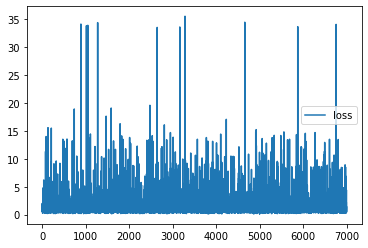

In [537]:
pd.DataFrame({'loss':loss_list},index=np.arange(len(loss_list))).plot()

# Rough

In [453]:
iterator=iter(dataloader)
feature, target,index=iterator.next()
i=15
print(feature[i,])
print(target[i,])
print(non_feature_array[index[i]])

tensor([[293.9300,   0.0000,   0.0000,   0.0000,   0.0000, 122.6000,   0.0000,
          64.8600,   0.0000,   0.0000],
        [525.8300,   0.0000,   0.0000,   0.0000,   0.0000,  98.9300,   0.0000,
          30.8900,   0.0000,   0.0000]])
tensor([[344.9200,   0.0000,   0.0000,   0.0000,   0.0000]])
[[Timestamp('2019-10-01 00:00:00') 'megadriving0b-20']
 [Timestamp('2019-11-01 00:00:00') 'megadriving0b-20']]


In [456]:
df_sample_1.query('store_id=="megadriving0b-20"')['Direct_OPS'].swaplevel(1,0,axis=1)['2019-10-01']


gl_top_30,-999,121.0,201.0,147.0,200.0
store_id,,,,,
megadriving0b-20,293.93,0.0,0.0,0.0,0.0


In [457]:
df_sample_1.query('store_id=="megadriving0b-20"')['Halo_OPS'].swaplevel(1,0,axis=1)['2019-10-01']

gl_top_30,-999,121.0,201.0,147.0,200.0
store_id,,,,,
megadriving0b-20,122.6,0.0,0.0,64.86,0.0


In [458]:
feature_names

Index(['Direct_OPS_-999', 'Direct_OPS_121.0', 'Direct_OPS_147.0',
       'Direct_OPS_200.0', 'Direct_OPS_201.0', 'Halo_OPS_-999',
       'Halo_OPS_121.0', 'Halo_OPS_147.0', 'Halo_OPS_200.0', 'Halo_OPS_201.0'],
      dtype='object')

In [475]:
i=0
print(feature[i,])
print(target[i,])
print(non_feature_array[index[i]])

tensor([[2815.2600,    0.0000,    0.0000,    0.0000,    0.0000,  644.3900,
           80.4200,   11.9900,   10.9800,   14.9800],
        [1381.0300,    0.0000,    0.0000,    0.0000,    0.0000,  756.5500,
            0.0000,    0.0000,    0.0000,    0.0000]])
tensor([[2290.5701,   19.8800,    0.0000,   23.9900,  170.3900]])
[[Timestamp('2020-01-01 00:00:00') 'kemesab-20']
 [Timestamp('2020-02-01 00:00:00') 'kemesab-20']]


In [470]:
feature_names

Index(['Direct_OPS_-999', 'Direct_OPS_121.0', 'Direct_OPS_147.0',
       'Direct_OPS_200.0', 'Direct_OPS_201.0', 'Halo_OPS_-999',
       'Halo_OPS_121.0', 'Halo_OPS_147.0', 'Halo_OPS_200.0', 'Halo_OPS_201.0'],
      dtype='object')

In [477]:
df_sample_1.query('store_id=="kemesab-20"')['Halo_OPS'].swaplevel(1,0,axis=1)['2020-01-01']


gl_top_30,-999,121.0,201.0,200.0,147.0
store_id,,,,,
kemesab-20,644.39,80.42,14.98,10.98,11.99


In [366]:
# train_dataloader=DataLoader(train_dataset, batch_size=30)
# test_dataloader=DataLoader(test_dataset, batch_size=30)

torch.Size([30, 2, 10])